## 1. CompressSensing class

CompressSesing class provides tools to read wav signal, build periodic signal multi-frequency, compress it with random sampling and recovered it with L1-minimimazation solver

In [140]:
import wave
import numpy as np
import matplotlib.pyplot as plt

from scipy.fftpack import fft, ifft
from scipy.stats import truncnorm
from scipy.sparse import csr_matrix


class CompressSensing:
    """ CompressSesing class provides tools to read wav signal, compress it and
    recovered original signal with L1-minimimazation solver

    Attributes
    ----------

    signal_t : bytearray, shape = [n_frames]
        Return temporal signal from wav format to 1-D numpy array.

    signal_f : bytearray
        Fast Fourier transformation of signal_t, express in frequency basis.

    n_frames : int
        Number of frames of intial signal.

    """

    def __init__(self):
        self.signal_t = np.array(0)
        self.signal_f = np.array(0)
        self.n_frames = 0

    def wav_to_array(self, filename):
        """ Open wav file as numpy array. Compute number of frames of input file.

            Parameters
            ----------
            filename : basestring
                Path to input wav

            Returns
            -------
            self : object

        """

        wf = wave.open(filename)
        self.n_frames = wf.getnframes()  # Returns number of audio frames
        frames = wf.readframes(self.n_frames)  # Reads and returns at most n_frames of audio, as a string of bytes
        self.signal_t = np.frombuffer(frames, dtype=np.int16)  # 1-D numpy array
        wf.close()

        return self

    def describe(self):
        """ Properties of temporal/frequency signal

            Returns
            -------

        """

        # TODO

    @staticmethod
    def cos_signal_maker(A0, f0, fe, n_frames):
        """ Create a signal of one frequence with cosinus :

            Parameters
            ----------
            A0 : float
                Signal amplitude

            f0 : float
                Signal frequency [Hz]

            fe : int
                Sampling frequency [Hz]

            n_frames : int
                Number of points of signal

            Returns
            -------
            signal_cos : bytearray, shape = [n_frames]
                signal periodic built from cos function

        """
        t = np.arange(n_frames) / fe  # time discretization
        signal_cos = A0 * np.cos(2 * np.pi * f0 * t)

        return signal_cos

    def periodic_signal_maker(self, A0=[2, 15], f0=[50, 100], fe=1000, t=1, noise_level=0, mean=0, std=1,
                              plot=False):
        """ Create a periodic signal with 1 or more cosinus. Noise computed from truncated normal law may be add.

            Parameters
            ----------
            A0 : bytearray, default = [2,15]
                Signal amplitude

            f0 : bytearray, default = [50,100]
                Signal frequency [Hz]

            fe : float, default = 1000
                Sampling frequency [Hz]

            t : float, default = 1
                length of signal [s]

            noise_level : float
                Noise level applied to amplitude of truncated normal law as follow:
                    noise_level * max(A0)
                In case of signal composed of several frequencies, noise level is computed from the maximum amplitude.

            mean : float
                Mean of truncated normal law

            std : float
                Standard deviation of truncated normal law

            plot : bool
                If True, plot periodic signal(s) in temporal basis, gaussian noise, superposition of both
                and signal in frequency basis

            Returns
            -------
        """

        n_signals = len(A0)
        self.n_frames = int(t*fe)
        signal_noiseless = np.zeros(self.n_frames).astype(float)

        for i in range(n_signals):
            signal_noiseless += self.cos_signal_maker(A0[i], f0[i], fe, self.n_frames)

        self.signal_t = signal_noiseless

        if noise_level != 0:
            start_trunc = -np.max(A0) * noise_level
            end_trunc = np.max(A0) * noise_level
            mean = 0
            std = 4
            a, b = (start_trunc - mean) / std, (end_trunc - mean) / std
            gaussian_noise = truncnorm.rvs(a, b, loc=mean, scale=std, size=self.n_frames)

            self.signal_t = signal_noiseless + gaussian_noise

        if plot and noise_level != 0 :

            plt.figure(figsize=(14, 9))

            plt.subplot(411)
            plt.plot(signal_noiseless)
            plt.xlim((0, 250))
            plt.title(f'Signal avec amplitude = {A0}, fréquence = {f0}, \n  fe = {fe}, points d\'échantillonage = {self.n_frames}')
            plt.xlabel('Temps [s]')
            plt.ylabel('Amplitude')

            plt.subplot(412)
            plt.title(f'Bruit gaussien de moyenne = {mean} et écart-type = {std}')
            plt.plot(gaussian_noise)
            plt.xlim((0, 250))
            plt.xlabel('Temps [s]')
            plt.ylabel('Amplitude')

            plt.subplot(413)
            plt.title('Signal bruité')
            plt.plot(self.signal_t)
            plt.xlim((0, 250))
            plt.xlabel('Temps [s]')
            plt.ylabel('Amplitude')

            plt.subplot(414)
            plt.title(f'Base de Fourier')
            plt.plot(fft(self.signal_t)/self.n_frames)
            plt.xlabel('Fréquence [Hz]')
            plt.ylabel('Amplitude')

        else:
            plt.figure(figsize=(14, 9))

            plt.subplot(211)
            plt.plot(signal_noiseless)
            plt.xlim((0, 250))
            plt.title(f'Signal avec amplitude = {A0}, fréquence = {f0}, \n  fe = {fe}, points d\'échantillonage = {self.n_frames}')
            plt.xlabel('Temps [s]')
            plt.ylabel('Amplitude')

            plt.subplot(212)
            plt.title(f'Base de Fourier')
            plt.plot(fft(self.signal_t)/self.n_frames)
            plt.xlabel('Fréquence [Hz]')
            plt.ylabel('Amplitude')

        return self

    def plot_signal(self, basis):
        """ Plot of signal. signal_t or signal_f attributes needs exist.

            Parameters
            ----------
            basis : string
                Define support of signal:
                    t = temporal
                    f = frequency

            Returns
            -------
            Plot : matplotlib.pyplot.plt
                Curve of input signal with matplotlib

        """

        if basis == 't':
            plt.figure(figsize=(10, 6))
            plt.plot(self.signal_t)
            plt.title('Signal en base temporelle', fontsize=15)
            plt.xlabel('Fréquence [Hz]', fontsize=15)
            plt.ylabel('Amplitude', fontsize=15)
            plt.xticks(fontsize=15)
            plt.yticks(fontsize=15)
            plt.show()

        if basis == 'f':
            signal_f_std = self.signal_f / self.n_frames
            X_frequencies = np.arange(-self.n_frames / 2, self.n_frames / 2)

            plt.figure(figsize=(10, 6))
            plt.plot(X_frequencies, abs(signal_f_std))
            plt.title('Signal en base fréquentielle', fontsize=15)
            plt.xlabel('Fréquence [Hz]', fontsize=15)
            plt.ylabel('Amplitude', fontsize=15)
            plt.show()

    def fft(self):
        """ Compute fast Fourier transformation of input temporal signal.

        """

        self.signal_f = fft(self.signal_t)

    def sampler_gauss(self, rate=0.5, signal_length=1, std=1, verbose=0):
        """ Method to compute the list of sampling instants according truncated normal law and sampling matrix.
            Value of truncated normal law is restricted to [0, dt] with dt = step-time. Mean is fixed at
            middle step time.

            Parameters
            ----------
                signal_length : float (default=1)
                    Signal lenght which have to be considered.
                        1 = all instants considered
                        0 = no instant considered

                rate : float (default=0.5)
                    Rate sampling computed as : considered_instants / initial_instants
                        1 = without sampling
                        0 = no one instant keep

                std : float (default=1)
                    Standard deviation of truncated normal law.

                verbose : boolean (default=0)
                    If verbose=1, displays parameters of sampling and truncated normal law.
                    Plot the curve of truncated normal law.

            Return
            ------
                sampling_instants : array of shape = [rate*n_frames]
                    Sampling instants of input signal.

                phi : scipy.sparse.csr_matrix object with rate*n_frames elements
                    Sampling matrix in compressed sparse row matrix format.

        """

        signal_t_trunc = self.signal_t[:int(signal_length * len(self.signal_t))]
        n_signal_t_trunc = len(signal_t_trunc)  # nombre d'échantillonnage total du signal d'entrée
        dt = int(1/rate)  # pas de temps
        X_sampled = np.arange(0, n_signal_t_trunc, dt)  # ensemble de discrétisation
        n_signal_t_sampled = len(X_sampled)

        # Construction de l'échantillonnage aléatoire selon loi normal tronquée (bornée entre [0, dt] )
        start_trunc = 0
        end_trunc = dt
        mean = end_trunc / 2
        a, b = (start_trunc - mean) / std, (end_trunc - mean) / std

        # Génération des valeurs aléatoires entre [0, DT]
        random_instants = np.ceil(truncnorm.rvs(a, b, loc=mean, scale=std, size=n_signal_t_sampled-1))
        random_instants = np.hstack((random_instants, [0]))

        # Vecteur des instants de l'échantillonnage aléatoire
        sampling_instants = (X_sampled + random_instants).astype('int')

        # Sampling matrix
        phi = np.zeros((n_signal_t_sampled, n_signal_t_trunc), dtype=int)

        for i in range(n_signal_t_sampled):
            phi[i, sampling_instants[i]] = 1

        phi = csr_matrix(phi)

        if verbose:
            # Représentation graphique
            x_range = np.linspace(0, end_trunc, 10000)
            plt.plot(x_range, truncnorm.pdf(x_range, a, b, loc=mean, scale=std))

            # Vérification cohérence de l'échantillonnage
            print(f'Est-ce que toutes les valeurs générées sont comprises dans [{start_trunc},{end_trunc}] ?\n'
                  f'>= {start_trunc} : {np.all(random_instants >= 0)}\n'
                  f'<= {end_trunc} : {np.all(random_instants <= end_trunc)}\n')

            print('\nCas d\'étude : \n'
                  '=============\n'
                  f'Echantillonnage gaussien, moyenne centrée sur l\'intervalle, variance {std}\n'
                  f'Definition du signal initial : {n_signal_t_trunc} \n'
                  f'Définition du signal échantilloné : {n_signal_t_sampled}\n'
                  f'Taux d\'échantillonnage : {rate:.3f}')

        return sampling_instants, phi

    @staticmethod
    def soft_threshold(x, w):
        """ Threshold function
        """
        return np.sign(x) * np.maximum(np.abs(x) - w, 0.)

    def recover(self, sampling_instants, phi, lambda_n=1, gamma=0.5, w=100, max_iter=100, cv_criterium=1e-3, verbose=0):
        """ Algorithm for minimazation of OLS with L1-constraint

            x^hat = argmin_x |y-Ax|^2 + |x|_1

            Parameters
            ----------
            sampling_instants : array
                Sampling instants computed with one of the sampler method

            phi : sampling matrix

            lambda_n : float (default=1)
                relaxation, applied to the proxima term

            gamma : float (default=0.5)
                learning right, applied to descent gradient term

            w : float (default=100)
                regularization value, applied to L1 norm.

            max_iter : int (default=100)
                Number max of iteration

            cv_criterium : float (default 1e-3)
                Convergence criterium on target fonction

            verbose : boolean (default=0)
                If verbose=1, displays parameters of sampling and truncated normal law.
                Plot the curve of truncated normal law.

            Return
            ------
            signal_t_recovered : array of shape = []
                Signal recovered expressed in temporal basis

        """

        # Initialisation du X_hat = signal à reconstruire en frequentiel
        X_hat = np.full(self.n_frames, 1e3)

        # Initialisation values
        iteration = 0
        signal_L1 = list()
        objective_fct = list()
        objective_fct.append(cv_criterium + 1)
        c = 1 / len(sampling_instants)

        # Matrice d'échantillonnage aléatoire
        y = self.signal_t[sampling_instants]  # Vecteur y à partir de l'échantillonnage aléatoire

        while iteration < max_iter and objective_fct[iteration] > cv_criterium:

            f1 = phi @ ifft(X_hat)
            grad = fft(phi.T @ f1) * c - np.real(fft(phi.T @ y) * c)
            z = X_hat - gamma*grad
            X_hat = X_hat + lambda_n * (self.soft_threshold(np.real(z), w) + 1j * self.soft_threshold(np.imag(z), w) - X_hat)

            signal_L1.append(np.linalg.norm(X_hat, 1))
            objective_fct.append(np.linalg.norm(f1 - y, 2) + lambda_n * np.linalg.norm(X_hat, 1))

            if verbose:
                print('Iteration : ', iteration)
                #   print(f'Data fidelity: {data_fidel[iteration]}')
                #   print(f'Norme1 de X_hat: {Xhat_L1[iteration]}\n')
                print(f'{iteration} : {objective_fct[iteration]:}')
                #    print('grad :',np.linalg.norm(grad,2))
                #    print('Z :',np.linalg.norm(Z,2))
                print('\n')

            iteration += 1

        signal_f_recovered = X_hat

        return signal_f_recovered, objective_fct, signal_L1

    @staticmethod
    def plot_recovery(signal_f_recovered, objective_fct, signal_L1):
        """ Plot curves of signal recovered and intermediate values.

            Parameters
            ----------
                objective_fct : bytearray
                    Value of objective function at each step of resolution

                signal_L1 : bytearray
                    Value of l1-norm at each step of resolution

                signal_f_recovered : bytearray
                    Signal recovered in temporal basis

            Returns
            -------
            Plot curves of signal recovered and intermediate values with matplotlib

        """

        plt.figure(figsize=(14, 10))

        plt.subplot(221)
        plt.plot(objective_fct, label='Fonction objective')
        plt.xticks(label='Iteration')

        plt.subplot(222)
        plt.hist(np.abs(signal_f_recovered), bins=50, label='Histogramme du signal reconstruit')

        plt.subplot(223)
        plt.plot(signal_L1, label='Norme L1 de X_hat')
        plt.xticks(label='Iteration')

        plt.subplot(224)
        plt.plot(signal_f_recovered, label='Signal reconstruit')

        plt.show()

    def plot_score(self, signal_f_recovered):

        """ Plot curves of signal recovered on signal to recover.

                    Parameters
                    ----------
                    signal_f_recovered : array
                        Signal recovered in frequential basis

                    Returns
                    -------
                    Plot curves of signal recovered on signal to recover with matplotlib

        """

        signal_f_std = self.signal_f / self.n_frames
        X_frequencies = np.arange(-self.n_frames / 2, self.n_frames / 2)

        plt.figure(figsize=(14, 7))
        plt.plot(X_frequencies, abs(signal_f_std), label='Signal à reconstruire')
        plt.xlabel('Fréquence [Hz]', fontsize=15)
        plt.ylabel('Amplitude', fontsize=15)
        plt.legend()

        signal_f_recovered = signal_f_recovered
        plt.plot(X_frequencies, abs(signal_f_recovered.real), label='Signal reconstruit', linestyle=':')
        plt.legend()
        plt.show()

## 2. Periodic signal

### 2.1. Une seule fréquence

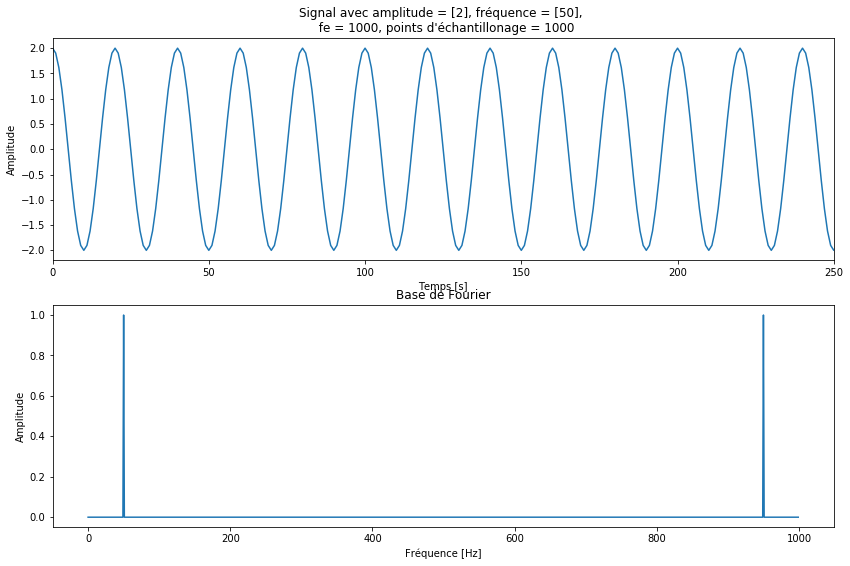

In [110]:
cs = CompressSensing()
cos1 = cs.periodic_signal_maker(A0=[2], f0=[50], fe=1000, t=1, noise_level=0, plot=True)

In [111]:
instants_cos1, phi_cos1 = cos1.sampler_gauss()

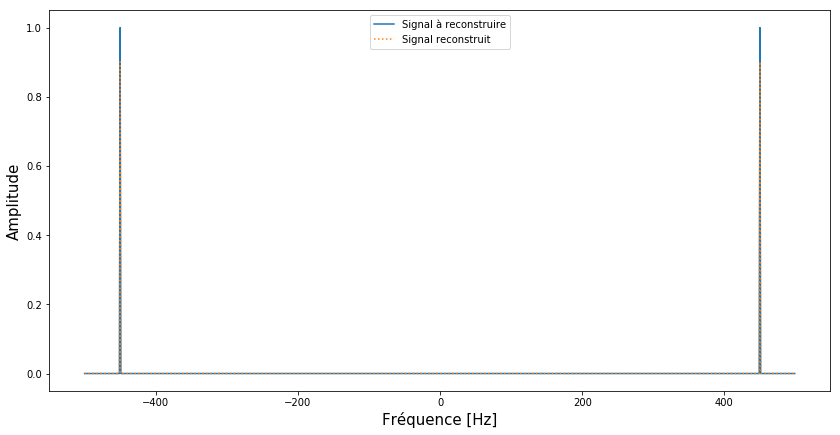

In [112]:
cos1.fft()
cos1_recovered, *_ = cos1.recover(instants_cos1, phi_cos1, w=10.475)
cos1.plot_score(cos1_recovered)

### 2.2. Signal périodique composé de 5 fréquences sans bruit

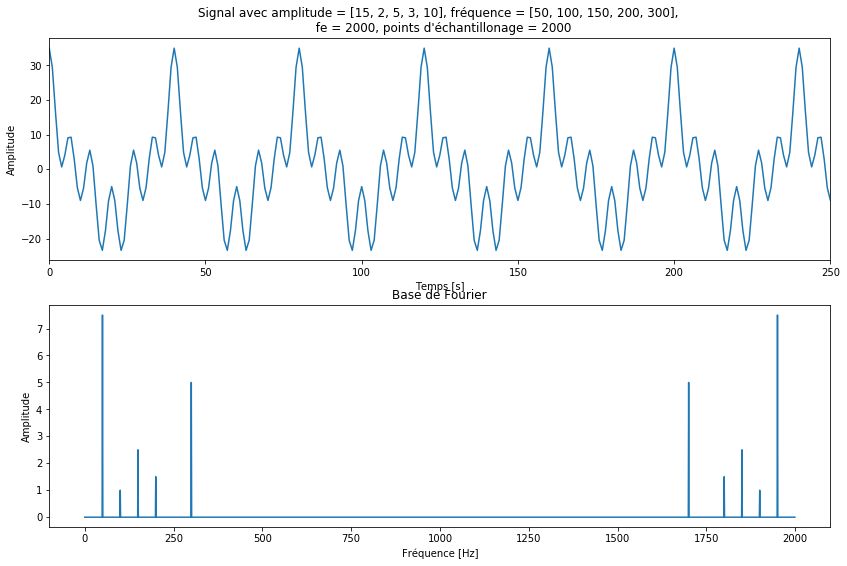

In [134]:
cs = CompressSensing()

A = [15, 2, 5, 3, 10]
f = [50, 100, 150, 200, 300]

cos2 = cs.periodic_signal_maker(A0=A, f0=f, fe=2000, t=1, noise_level=0, plot=True)

In [114]:
instants_cos2, phi_cos2 = cos2.sampler_gauss()

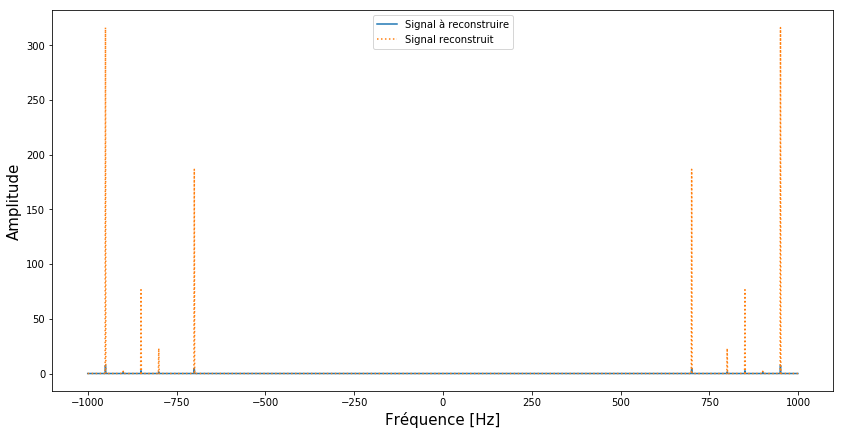

In [127]:
cos2.fft()
cos2_recovered, *_ = cos2.recover(instants_cos2, phi_cos2, w=10.5)
cos2.plot_score(cos2_recovered)

### 2.2. Signal périodique composé de 5 fréquences avec bruit

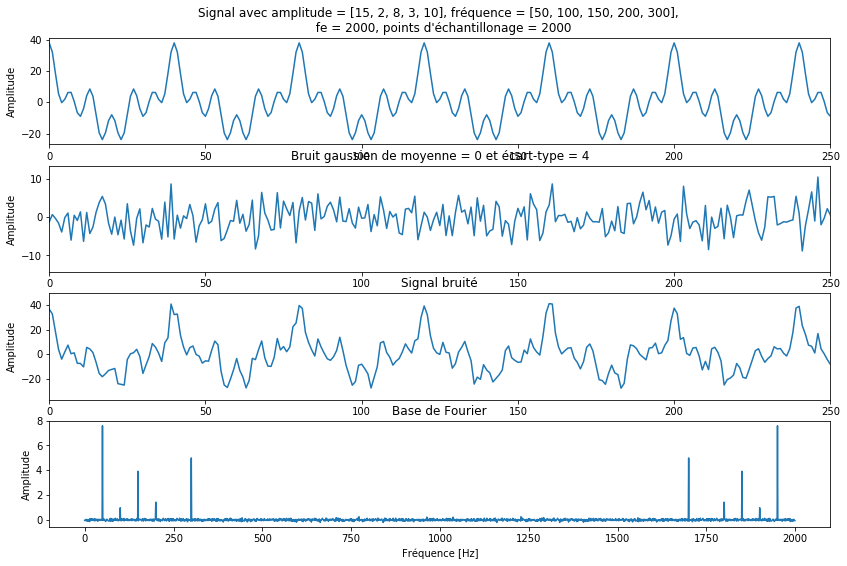

In [161]:
cs = CompressSensing()

A = [15, 2, 8, 3, 10]
f = [50, 100, 150, 200, 300]

cos3 = cs.periodic_signal_maker(A0=A, f0=f, fe=2000, t=1, noise_level=3, plot=True)

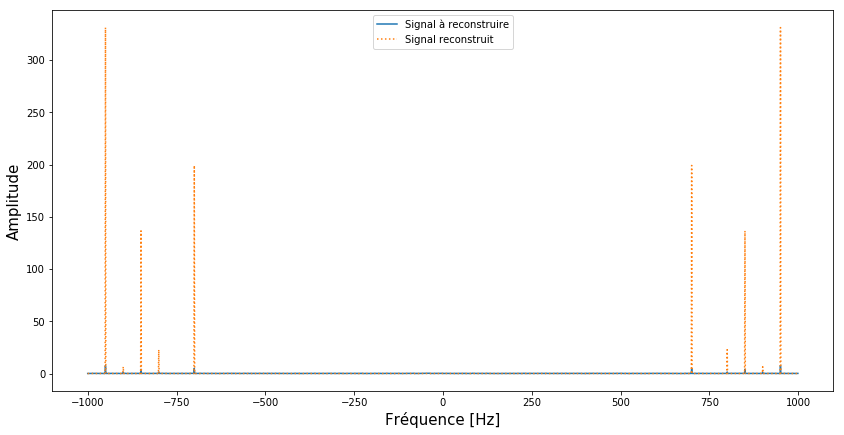

In [171]:
instants_cos3, phi_cos3 = cos3.sampler_gauss()
cos3.fft()
cos3_recovered, *_ = cos3.recover(instants_cos3, phi_cos3, w=10.43)
cos3.plot_score(cos3_recovered)

## 3.  Signal measured

In [173]:
cs = CompressSensing()
c01 = cs.wav_to_array('signals_wav/C_01.wav')

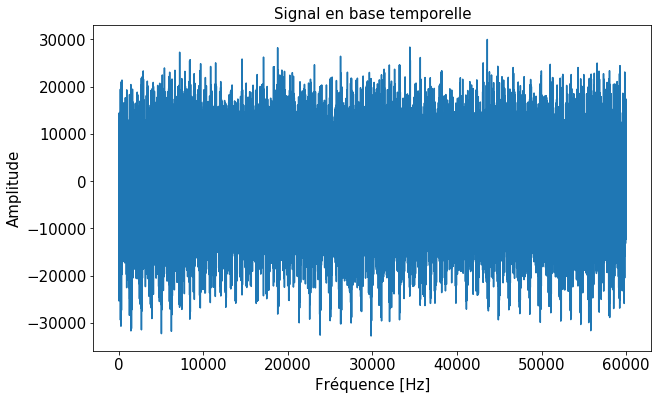

In [174]:
c01.plot_signal(basis='t')

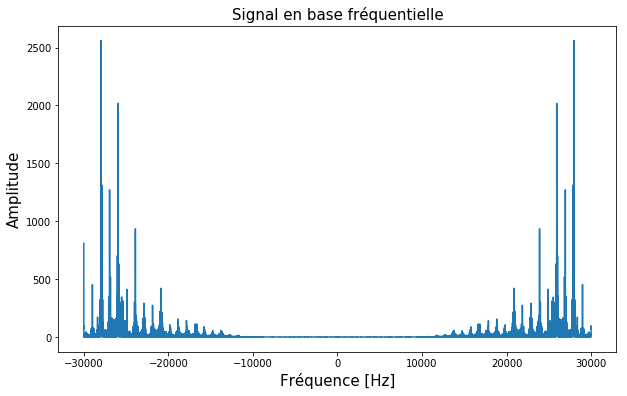

In [175]:
c01.fft()
c01.plot_signal(basis='f')

In [176]:
instants_c01, phi_c01 = c01.sampler_gauss()

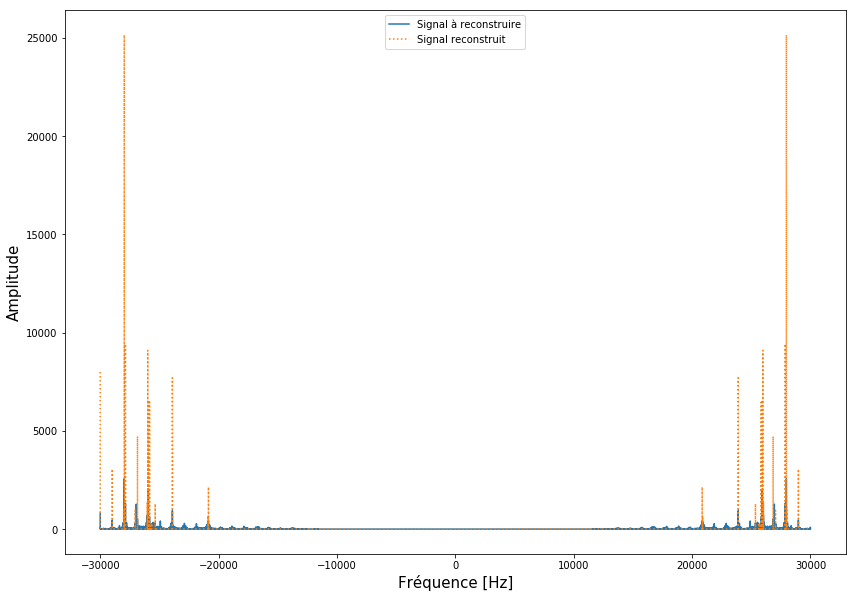

In [183]:
recovered_c01, obj_fct_c01, L1_c01 = c01.recover(sampling_instants=instants_c01, \
                                                                    phi=phi_c01, w=130, max_iter=30)

#c01.plot_recovery(recovered_c01, obj_fct_c01, L1_c01)
signal_c01.plot_score(recovered_c01)

### A faire :
1. Converger
2. Jouer avec le bruit
3. Créer un notebook propre
4. Passer aux données Safran